In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

In [4]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [5]:
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [6]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [7]:
# Normalize data to black and white
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

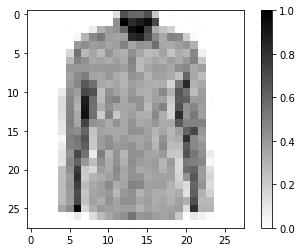

In [8]:
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

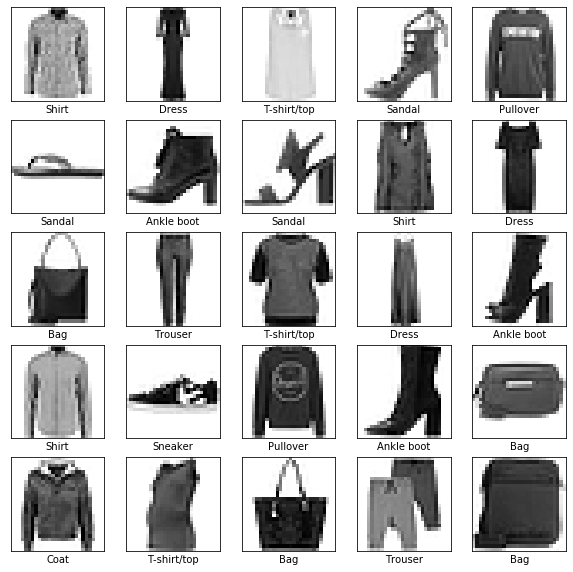

In [9]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(test_dataset.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

In [11]:
# CNN
model = keras.Sequential([
    # Convolution layer
    # 32 3x3 filters 
    # Padded to retain image size after filters
    # Using the relu activation function
    # Input shape is 28x28 matrix
    layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, input_shape=(28,28,1)),
    # Max pooling layer
    # Uses a 2x2 matrix with a stride of 2
    layers.MaxPooling2D((2,2), strides=2),
    # Another conv layer with 64 outputs
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    # Max pool again
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    # Flatten Layer
    layers.Flatten(),
    # Standard activation function
    layers.Dense(128, activation=tf.nn.relu),
    # Softmax to classify as a single class
    layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [12]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [14]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Train for 1875 steps
Epoch 1/10
1875/1875 [==============================] - 33s 18ms/step - loss: 0.4053 - accuracy: 0.8538
Epoch 2/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.2664 - accuracy: 0.9030
Epoch 3/10
1875/1875 [==============================] - 38s 21ms/step - loss: 0.2188 - accuracy: 0.9191
Epoch 4/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.1839 - accuracy: 0.9324
Epoch 5/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.1620 - accuracy: 0.9405
Epoch 6/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.1369 - accuracy: 0.9491
Epoch 7/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.1154 - accuracy: 0.9576
Epoch 8/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0987 - accuracy: 0.9636
Epoch 9/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0845 - accuracy: 0.9690
Epoch 10/10
1875/1875 [====================

In [15]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 9s 28ms/step - loss: 0.3051 - accuracy: 0.9209
Accuracy on test dataset: 0.9209


In [16]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [17]:
predictions.shape

(32, 10)

In [18]:
predictions[0]

array([2.28537970e-11, 3.87217869e-10, 2.36845281e-05, 7.14957082e-07,
       7.35026747e-02, 3.43579221e-10, 9.26472902e-01, 5.15658760e-09,
       1.04214015e-08, 3.85646111e-08], dtype=float32)

In [19]:
np.argmax(predictions[0])

6

In [20]:
test_labels[0]

6

In [21]:
def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[...,0], cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                            100*np.max(predictions_array),
                                            class_names[true_label]),
                                            color=color)
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

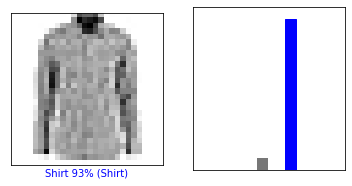

In [22]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

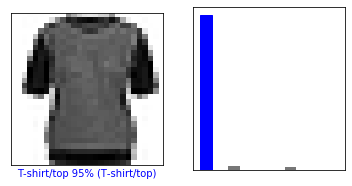

In [23]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

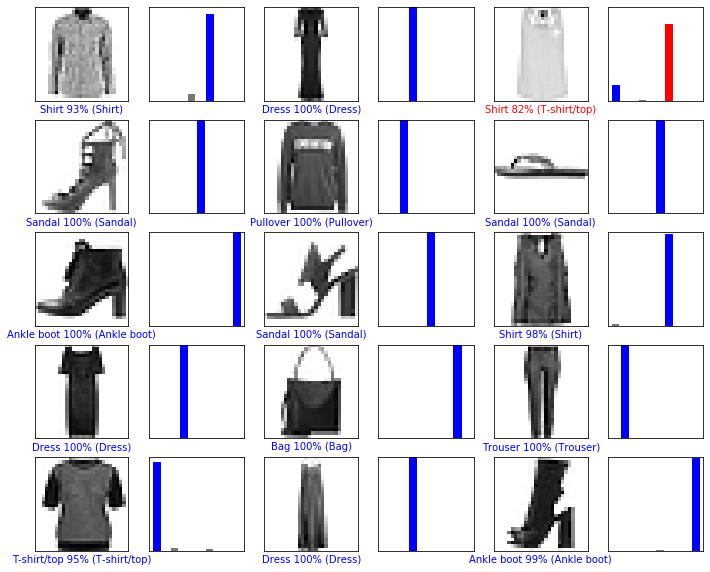

In [24]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
